## 参考サイト
https://qiita.com/Cartelet/items/fd1d6eeb395cf572d6a2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact
import requests
from PIL import Image
import io

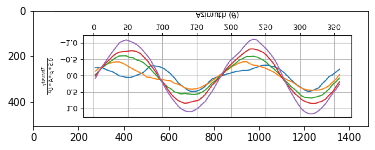

In [2]:
path = "/Users/yuki2001/Library/CloudStorage/Box-Box/02. 学生アルバイト共有/QBlade/comparison_DTU_Tunnel_experiment/thesis_figure/Cty_azm.png"
im = plt.imread(path) #画像をnumpy配列に変換
if im.shape[2] == 4:im = im[:,:,:-1] 
if im.max() > 1:im /= 255 #0-1に正規化
h, w, _ = im.shape
plt.imshow(im[::-1]) #上下反転

In [3]:
#後のスケール調節用にグラフの範囲のみトリミング
#できるだけ正の領域のみか負の領域のみにする
@interact(x_min=(0, w), x_max=(0, w), y_min=(0,h), y_max=(0,h))
def Plot(x_min=0, x_max=w, y_min=0, y_max=h):
    global imag
    plt.figure(figsize=(7, 7))
    imag = im[min(y_min,y_max-1):max(y_min+1, y_max), min(x_min,x_max-1):max(x_min+1, x_max)]
    plt.imshow(imag[::-1])

interactive(children=(IntSlider(value=0, description='x_min', max=1482), IntSlider(value=1482, description='x_…

In [4]:
x_all = imag.shape[1]
y_all = imag.shape[0]

In [5]:
#基準となる長さになるように切り取る
#元のグラフのちょうどメモリのところで切り取ればその範囲が元のメモリでどのくらいの大きさになるのかがわかる
#基準となる長さを利用してスケールを後ほど調整する
@interact(x_min=(0, w), x_max=(0, w), y_min=(0,h), y_max=(0,h))
def Plot(x_min=0, x_max=w, y_min=0, y_max=h):
    global imag_ref
    plt.figure(figsize=(7, 7))
    imag_ref = im[min(y_min,y_max-1):max(y_min+1, y_max), min(x_min,x_max-1):max(x_min+1, x_max)]
    plt.imshow(imag_ref[::-1])

interactive(children=(IntSlider(value=0, description='x_min', max=1482), IntSlider(value=1482, description='x_…

In [6]:
x_ref = imag_ref.shape[1] #0-350degreeに対応
y_ref = imag_ref.shape[0] #0-1(Ct)に対応

In [7]:
#正の領域と負の領域が存在する場合は、負の領域のみ切り取ってその部分の長さを知る必要がある
#今回はyが負の領域だけ切り取る
@interact(x_min=(0, w), x_max=(0, w), y_min=(0,h), y_max=(0,h))
def Plot(x_min=0, x_max=w, y_min=0, y_max=h):
    global imag_neg
    plt.figure(figsize=(7, 7))
    imag_neg = im[min(y_min,y_max-1):max(y_min+1, y_max), min(x_min,x_max-1):max(x_min+1, x_max)]
    plt.imshow(imag_neg[::-1])

interactive(children=(IntSlider(value=0, description='x_min', max=1482), IntSlider(value=1482, description='x_…

In [8]:
#x_neg = imag_neg.shape[1] 
y_neg = imag_neg.shape[0] #負の領域の長さ

In [20]:
#色域選択で抽出したいグラフを選択, Threshold(閾値)を調節して無駄な部分が入らないようにする
@interact(x=(0, imag.shape[1]), y=(0,imag.shape[0]), thresh=(1,10))
def Plot(x, y, thresh):
    global p
    p = ((imag - imag[y, x]) ** 2).sum(axis=2) < (1 / (1 <<thresh))
    print(p.sum())
    plt.imshow(p[::-1])
    plt.plot([x, x], [0, imag.shape[0]], color="r")
    plt.plot([0, imag.shape[1]], [imag.shape[0]-y, imag.shape[0]-y], color="r")

interactive(children=(IntSlider(value=547, description='x', max=1095), IntSlider(value=181, description='y', m…

In [37]:
#縦軸方向に平均を取る
p = np.pad(p, 1, "constant")
sx = np.arange(len(p[0]))[p.argmax(axis=0)!=0]
sy = []

for i in p.T:
    j = np.where(i!=0)[0]
    if j.tolist():
        sy.append(j.mean())

In [38]:
#サンプル数の選択, 移動平均（畳み込み）でノイズの除去
@interact(sample=(5, 1250), conv_size=(1, 21, 2))
def fit(sample, conv_size):
    global x,y
    x = np.linspace(sx.min(), sx.max(), sample)
    y = np.convolve(np.pad(np.interp(x, sx, sy), (conv_size-1)//2, "edge"), np.ones(conv_size) / conv_size, "valid")
    plt.plot(x, y)
    plt.xlim(0,len(p[0]))
    plt.ylim(0, len(p))

interactive(children=(IntSlider(value=627, description='sample', max=1250, min=5), IntSlider(value=11, descrip…

In [39]:
#切り取ったしたグラフのx軸、y軸の範囲を計算
xmin = 0
xmax = 350*x_all/x_ref #x_refが対応する範囲を利用
xl = [xmin, xmax]

ymin = -1*y_neg/y_ref
ymax = 1*(y_all-y_neg)/y_ref #y_refが対応する範囲を利用
yl = [ymin, ymax]



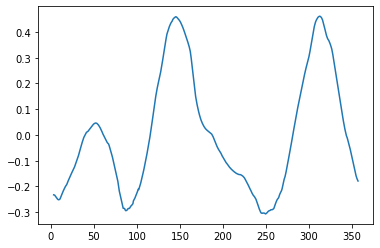

In [40]:
#1画素あたりの長さを計算

x_out = x * (xl[1] - xl[0]) / p.shape[1] + xl[0]

#最初numpy配列として読み込んだ画像について、行の向きと元の画像のy軸の向きを合わせるために上下反転しているので、y座標を反転して元に戻す
y_out = (p.shape[0]- y) * (yl[1] - yl[0]) / p.shape[0] + yl[0]

plt.plot(x_out, y_out)

In [14]:
#tsr3.7
x_out_tsr = {}
y_out_tsr = {}  
x_out_tsr[3.7]=x_out
y_out_tsr[3.7]=y_out

In [19]:
x_out_tsr[3.5]=x_out
y_out_tsr[3.5]=y_out

In [31]:
x_out_tsr[3.3]=x_out
y_out_tsr[3.3]=y_out

In [36]:
x_out_tsr[3.1]=x_out
y_out_tsr[3.1]=y_out

In [41]:
x_out_tsr[2.9]=x_out
y_out_tsr[2.9]=y_out

In [135]:
import pandas as pd
Ctx_azm_azm = pd.DataFrame(dict([(f'{k}_azm', pd.Series(v)) for k, v in x_out_tsr.items()]))
Ctx_azm_ctx = pd.DataFrame(dict([(f'{k}', pd.Series(v)) for k, v in y_out_tsr.items()]))
Ctx_azm = pd.concat([Ctx_azm_azm, Ctx_azm_ctx], axis=1)
Ctx_azm.to_csv('Ctx_azm.csv', index=False)
Ctx_azm


,3.7_azm,3.5_azm,3.3_azm,3.1_azm,2.9_azm,3.7,3.5,3.3,3.1,2.9
0,2.935804,3.262005,15.657624,2.935804,2.935804,-0.034472,0.000254,0.077150,-0.089715,0.144426
1,3.500663,3.825300,16.201639,3.500663,3.500142,-0.033861,0.002503,0.078985,-0.089104,0.147102
2,4.065521,4.388595,16.745654,4.065521,4.064479,-0.032639,0.005279,0.081123,-0.088493,0.150768
3,4.630380,4.951890,17.289668,4.630380,4.628816,-0.031417,0.008582,0.083872,-0.087882,0.154947
4,5.195238,5.515185,17.833683,5.195238,5.193154,-0.029890,0.012248,0.087238,-0.086906,0.159703
...,...,...,...,...,...,...,...,...,...,...
622,354.277708,353.631560,354.034881,354.277708,353.953592,0.013916,-0.017358,0.034006,-0.060673,0.046504
623,354.842566,354.194855,354.578896,354.842566,354.517929,0.008239,-0.021825,0.032249,-0.062938,0.051685
624,355.407425,354.758150,355.122911,355.407425,355.082266,0.003091,-0.025491,0.030535,-0.065076,0.056145
625,355.972283,355.321445,355.666926,355.972283,355.646604,-0.000991,-0.028878,0.028863,-0.067035,0.059884


In [43]:
import pandas as pd
Cty_azm_azm = pd.DataFrame(dict([(f'{k}_azm', pd.Series(v)) for k, v in x_out_tsr.items()]))
Cty_azm_cty = pd.DataFrame(dict([(f'{k}', pd.Series(v)) for k, v in y_out_tsr.items()]))
Cty_azm = pd.concat([Cty_azm_azm, Cty_azm_cty], axis=1)
Cty_azm.to_csv('Cty_azm.csv', index=False)


In [136]:
Cty_azm

,3.7_azm,3.5_azm,3.3_azm,3.1_azm,2.9_azm,3.7,3.5,3.3,3.1,2.9
0,3.262010,3.262010,2.935809,2.935809,2.935809,-0.016580,0.023622,0.031070,-0.071019,0.166168
1,3.826349,3.825828,3.500669,3.500669,3.278796,-0.015205,0.025505,0.031157,-0.070391,0.167521
2,4.390687,4.389645,4.065528,4.065528,3.621782,-0.013322,0.028047,0.031203,-0.069763,0.169203
3,4.955025,4.953462,4.630387,4.630387,3.964768,-0.010911,0.031131,0.031206,-0.069136,0.171345
4,5.519363,5.517279,5.195247,5.195247,4.307754,-0.008400,0.034444,0.031390,-0.068263,0.174001
...,...,...,...,...,...,...,...,...,...,...
1026,NaN,NaN,NaN,NaN,354.839591,NaN,NaN,NaN,NaN,0.080669
1027,NaN,NaN,NaN,NaN,355.182577,NaN,NaN,NaN,NaN,0.083378
1028,NaN,NaN,NaN,NaN,355.525563,NaN,NaN,NaN,NaN,0.085827
1029,NaN,NaN,NaN,NaN,355.868550,NaN,NaN,NaN,NaN,0.087966
